# lesson_2_DAN_CNN_Word2Vec_Embeddings_Classifier

**Description:** Text classification on the IMDB movie dataset using i) Deep Averaging Networks, and ii) Convolutions Neural Nets (CNN) and pre-trained Word2Vec word embeddings.<br>

Section 1 deals with setup and prerequisites, which does not need a lot of discussion. 
Data acquisition and preparation are handled in section 2, and section 3 looks at DANs and CNNs.

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup) 
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Averaging Network (AN) Model](#averagingNetwork)
    * 3.2 [Deep Averaging Network (DAN)](#modelDAN)
    * 3.3 [Convolutional Neural Net (CNN)](#modelCNN)
    * 3.4 [In-Class Exercises](#inClassExercises)

  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/materials/lesson_notebooks/lesson_2_DAN_CNN_text_classification_notebook.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally. 

In [1]:
!pip install gensim==3.8.3 --quiet

     |████████████████████████████████| 24.2 MB 1.3 MB/s 


In [2]:
!pip install tensorflow-datasets --quiet

In [3]:
!pip install -U tensorflow-text==2.8.2 --quiet

     |████████████████████████████████| 4.9 MB 16.5 MB/s 


pydot is also required, along with **graphviz**.

In [4]:
!pip install pydot --quiet

Ready to do the imports.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

import numpy as np

Below is a helper function to plot histories.

In [6]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from nltk.

In [7]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [8]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

How many words are in the vocabulary?

In [10]:
len(model.vocab)

43981

How do the word vectors look like? As expected:

In [11]:
model['great']

array([ 3.06035e-02,  8.86877e-02, -1.21269e-02,  7.61965e-02,
        5.66269e-02, -4.24702e-02,  4.10129e-02, -4.97567e-02,
       -3.64328e-03,  6.32889e-02, -1.42608e-02, -7.91111e-02,
        1.74877e-02, -3.83064e-02,  9.26433e-03,  2.95626e-02,
        7.70293e-02,  9.49334e-02, -4.28866e-02, -2.95626e-02,
        4.45244e-05,  6.82854e-02,  1.73836e-02,  3.14363e-02,
        6.53708e-02,  2.89380e-02, -4.39275e-02,  1.78000e-02,
        1.82164e-02, -4.70503e-02, -2.85216e-02,  1.79041e-02,
        1.06592e-01,  9.07696e-02,  6.78690e-02,  6.16755e-03,
       -2.08187e-02,  5.95936e-03,  1.51586e-03,  8.95205e-02,
        6.49544e-02, -3.12281e-02,  9.24351e-02, -2.45661e-02,
       -1.21269e-02, -1.53538e-03,  6.49544e-02, -1.12421e-02,
        9.10819e-03, -6.45380e-02,  4.43439e-02,  1.35738e-01,
       -7.91111e-02,  1.57181e-02, -4.72585e-02, -1.35322e-02,
       -4.33029e-02, -5.16304e-02,  1.37404e-01, -3.12281e-02,
       -6.49544e-02,  1.14087e-01, -6.41217e-02, -5.246

We can now build the embedding matrix and a vocabulary dictionary:

In [12]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [13]:
embedding_matrix.shape

(43982, 300)

In [14]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [15]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5JA718/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5JA718/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5JA718/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [16]:
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [17]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [18]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

Next, we tokenize the data:

In [19]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [20]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [21]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [22]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [23]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  0


Let's convince ourselves that the data looks correct:

In [24]:
train_input[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958,  5589,  8092, 43981, 34516, 43981,  8092, 16182, 43981,
        39933, 43981, 12139,  2326, 32781, 32467,  7046, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [25]:
train_labels[:4]

array([0, 0, 0, 1])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling

<a id = 'averagingNetwork'></a>
### 3.1 Averaging Network (AN) Model

Let us start by defining the embedding layer, then we'll average the embeddings and pass them into our classification layer.

In [26]:
an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [27]:
an_embedding_layer = Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)

In [28]:
an_embeddings = an_embedding_layer(an_input_layer)

In [29]:
an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)

In [30]:
an_classification = tf.keras.layers.Dense(1, 
                                          activation='sigmoid', 
                                          name='an_classification')(an_avg_embeddings)

In [31]:
an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])

In [32]:
an_model.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    amsgrad=False,
                                                    name='Adam'),
                 metrics='accuracy')

In [33]:
an_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_classification (Dense)   (None, 1)                 301       
                                                                 
Total params: 13,194,901
Trainable params: 301
Non-trainable params: 13,194,600
_________________________________________________________________


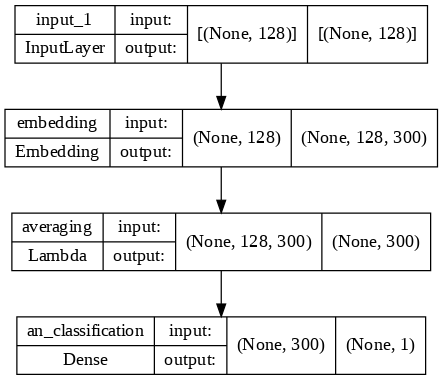

In [34]:
keras.utils.plot_model(an_model, show_shapes=True, dpi=90)

Let's look at the predictions and labels before training. Do those make sense?

In [35]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

predictions:
 [[0.49747592]
 [0.4978235 ]
 [0.5029473 ]
 [0.49828908]
 [0.5005155 ]]


labels:
 [0 0 0 1 1]


In [36]:
an_history = an_model.fit(train_input,
                          train_labels,
                          validation_data=(test_input, test_labels),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
625/625 [==============================] - 3s 3ms/step - loss: 0.6875 - accuracy: 0.5834 - val_loss: 0.6834 - val_accuracy: 0.6464
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6775 - accuracy: 0.6468 - val_loss: 0.6754 - val_accuracy: 0.6354
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6689 - accuracy: 0.6634 - val_loss: 0.6681 - val_accuracy: 0.6532
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6613 - accuracy: 0.6680 - val_loss: 0.6617 - val_accuracy: 0.6554
Epoch 5/20
625/625 [==============================] - 2s 2ms/step - loss: 0.6544 - accuracy: 0.6730 - val_loss: 0.6558 - val_accuracy: 0.6618
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6480 - accuracy: 0.6791 - val_loss: 0.6508 - val_accuracy: 0.6658
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6422 - accuracy: 0.6827 - val_loss: 0.6452 - val_accuracy: 0.6720
Epoch 

Let's revisit the predictions. How is this?

In [37]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

predictions:
 [[0.32614532]
 [0.31061164]
 [0.5986833 ]
 [0.6317239 ]
 [0.5299526 ]]


labels:
 [0 0 0 1 1]


That learned somewhat, can we do better?

[Return to Top](#returnToTop)  
<a id = 'modelDAN'></a>
### 3.2. Deep Averaging Network (DAN)

Now let's add some hidden layers after the averaging layer, to give our model more depth. The first and last layers are the same as above.

We'll also put our model creation code into a function, with variables for the things we can change (in this case, the hidden layers). Then we can try different values later.

In [38]:
def build_dan_model(hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)
    
    dan_classification = tf.keras.layers.Dense(1,
                                               activation='sigmoid',
                                               name='dan_classification')(last_hidden_output)
    
    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

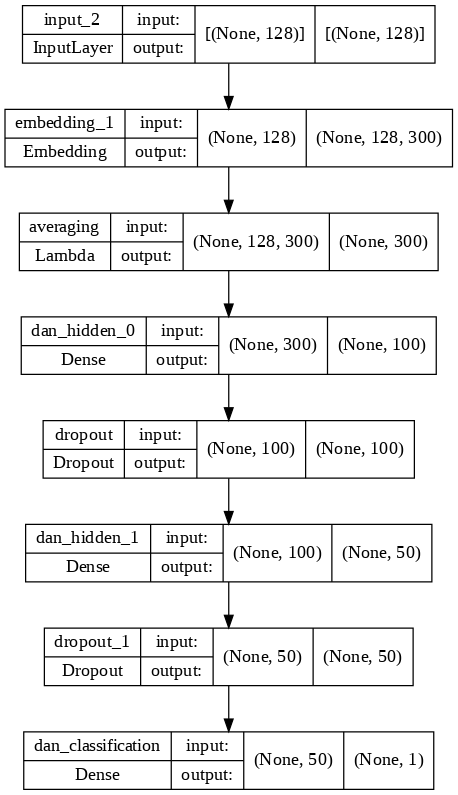

In [39]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5

dan_model = build_dan_model(hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [40]:
dan_history = dan_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20
625/625 [==============================] - 3s 3ms/step - loss: 0.6423 - accuracy: 0.6262 - val_loss: 0.5657 - val_accuracy: 0.7190
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.5360 - accuracy: 0.7375 - val_loss: 0.5130 - val_accuracy: 0.7496
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.5127 - accuracy: 0.7520 - val_loss: 0.5178 - val_accuracy: 0.7474
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4992 - accuracy: 0.7624 - val_loss: 0.4855 - val_accuracy: 0.7638
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4895 - accuracy: 0.7659 - val_loss: 0.4848 - val_accuracy: 0.7676
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4854 - accuracy: 0.7675 - val_loss: 0.4741 - val_accuracy: 0.7732
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4803 - accuracy: 0.7715 - val_loss: 0.4901 - val_accuracy: 0.7576
Epoch 

Below is a sample plot for two different models:

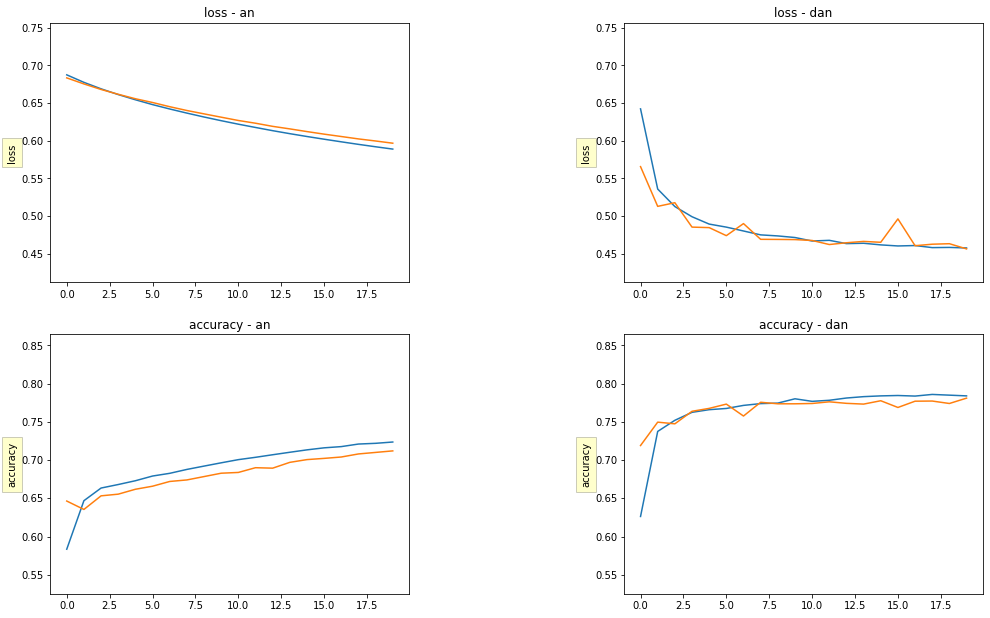

In [41]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          an_history,
          dan_history,
          model_1_name='an',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Of course, the avergaing network is not done training.

[Return to Top](#returnToTop)  
<a id = 'modelCNN'></a>
### 3.3 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [42]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [43]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [44]:
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 128, 300)     13194600    ['input_3[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 126, 100)     90100       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 125, 100)     120100      ['embedding_2[0][0]']            
                                                                                            

The keras plot utility shows this probably a bit nicer:

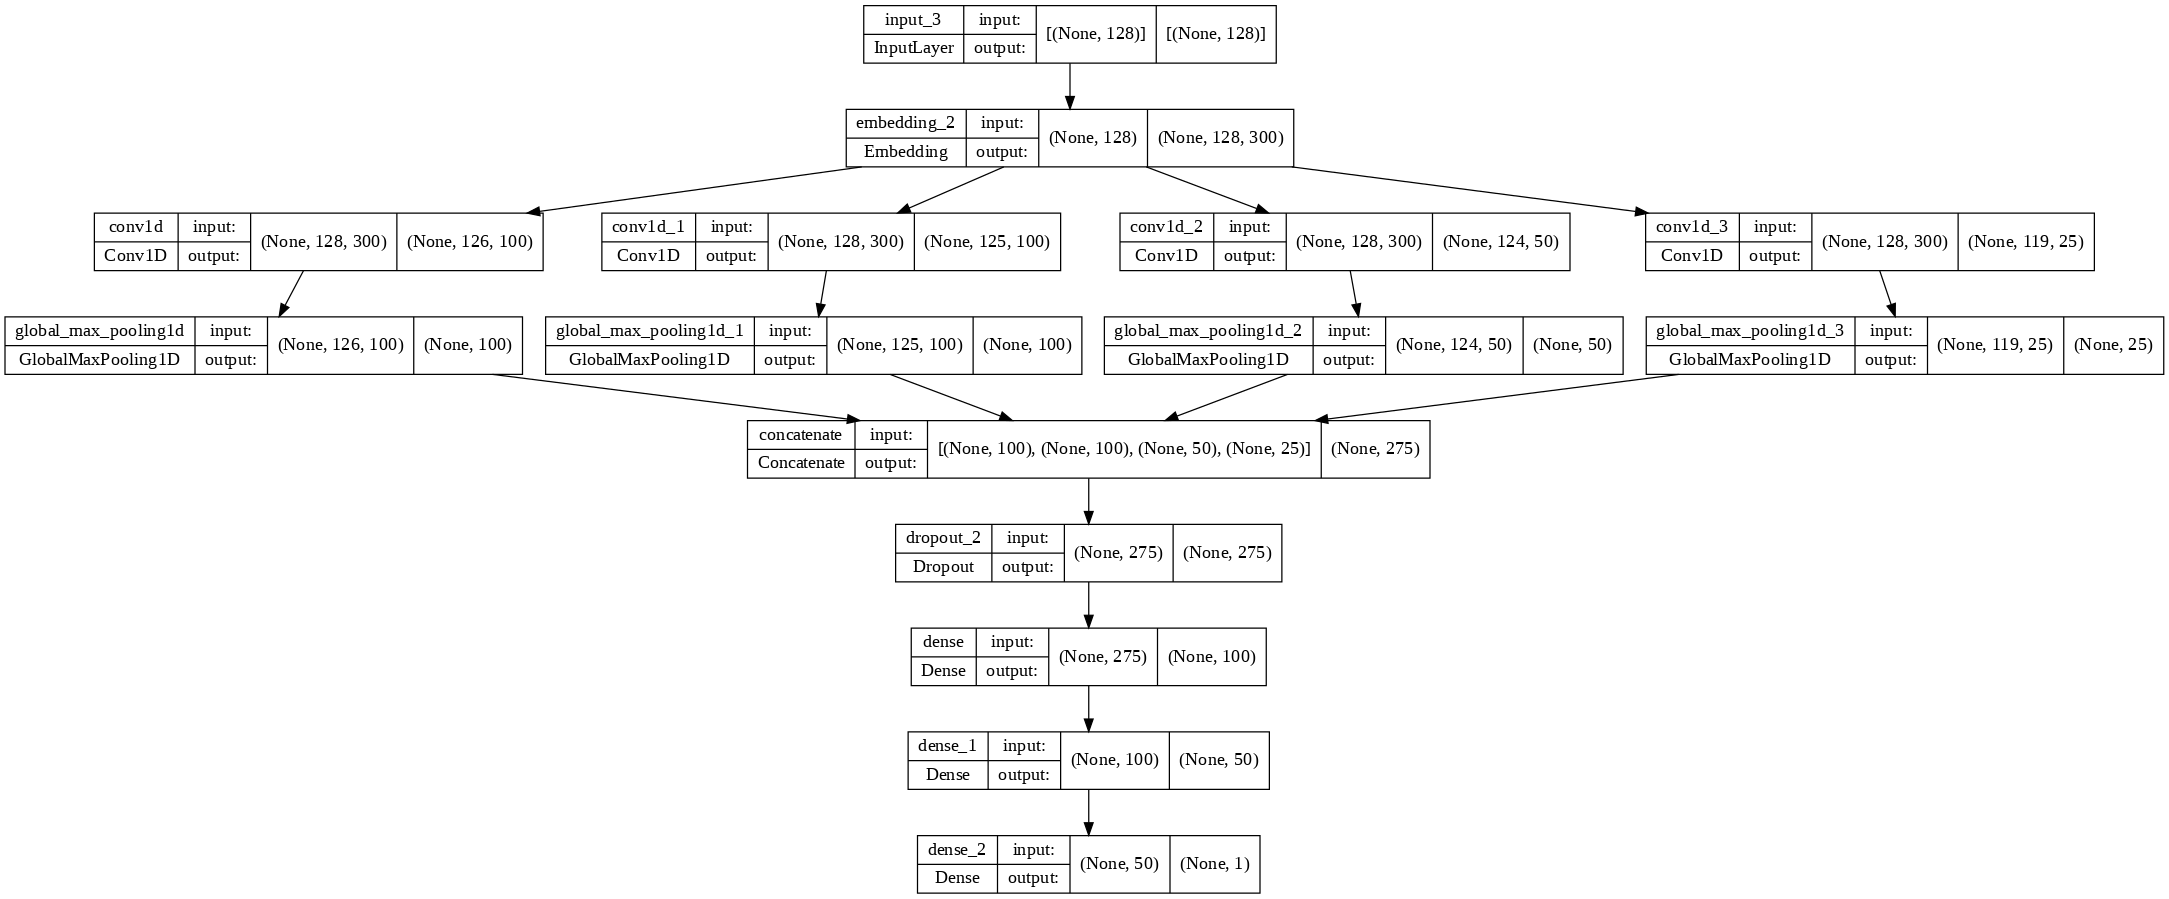

In [45]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [46]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 [==============================] - 15s 8ms/step - loss: 0.5471 - accuracy: 0.7035 - val_loss: 0.4282 - val_accuracy: 0.8098
Epoch 2/5
625/625 [==============================] - 4s 6ms/step - loss: 0.4221 - accuracy: 0.8058 - val_loss: 0.4142 - val_accuracy: 0.8112
Epoch 3/5
625/625 [==============================] - 4s 6ms/step - loss: 0.3692 - accuracy: 0.8400 - val_loss: 0.4154 - val_accuracy: 0.8150
Epoch 4/5
625/625 [==============================] - 4s 6ms/step - loss: 0.3237 - accuracy: 0.8598 - val_loss: 0.4458 - val_accuracy: 0.8020
Epoch 5/5
625/625 [==============================] - 4s 7ms/step - loss: 0.2800 - accuracy: 0.8824 - val_loss: 0.4196 - val_accuracy: 0.8216


Below is a comparison of a CNN model with a DAN model: 

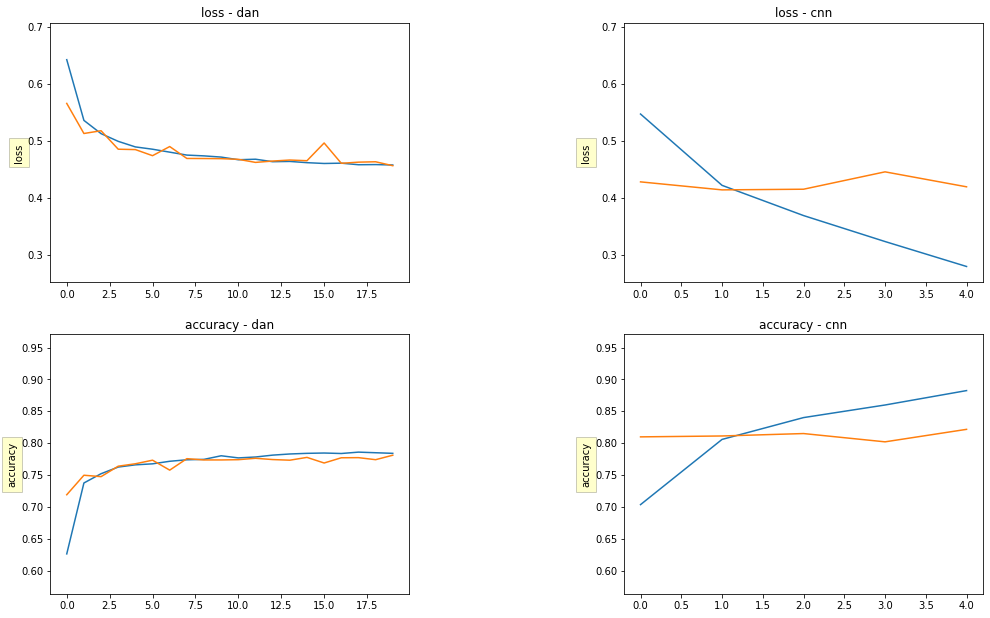

In [47]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_history, 
          cnn_history, 
          model_1_name='dan',
          model_2_name='cnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'inClassExercises'></a>
### 3.4. In-Class Exercises

A. Are any of the models above overfitting? Can you make them overfit less, or more? What parameters might you change to make these models more or less likely to overfit? How good (or bad) can you make it get?

> Hint: think about all of the options you can vary, including:
* add/remove more hidden layers
* vary dropout rates and dimensions
* enable/disable retraining of embedding matrix
* (for CNN) change number of filters
* (for CNN) change kernel sizes of filters
>
> For the option(s) you choose, do you think it will make the model more or less likely to overfit? Try it, does it work the way you expect?


B. Can you make any of these models train faster (or slower)? What parameters might you change to make that happen? Again, does it work how you expect when you try it?

You can use the cells below to explore either/both the DAN and CNN, using the functions defined above.

In [ ]:
# DAN model hyperparameters: Change these?
hidden_layer_sizes = [100, 50]
dropout_rate = 0.5
embeddings_trainable = False

dan_model2 = build_dan_model(hidden_layer_sizes, dropout_rate,
                             embeddings_trainable)

dan_history2 = dan_model2.fit(train_input,
                              train_labels,
                              validation_data=(test_input, test_labels),
                              batch_size=32,
                              epochs=20
                              )

In [ ]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_history,
          dan_history2,
          model_1_name='dan v1',
          model_2_name='dan v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
# CNN model hyperparameters: Change these?
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5
embeddings_trainable = False

cnn_model2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims,
                            dropout_rate, embeddings_trainable)

cnn_history2 = cnn_model2.fit(train_input,
                              train_labels,
                              validation_data=(test_input, test_labels),
                              batch_size=32,
                              epochs=5
                              )

In [ ]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history2,
          model_1_name='cnn v1',
          model_2_name='cnn v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

This finalizes the discussions of DANs and CNNs.

Over the next 2 weeks we will first add RNNs and then also classification with BERT.